In [42]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

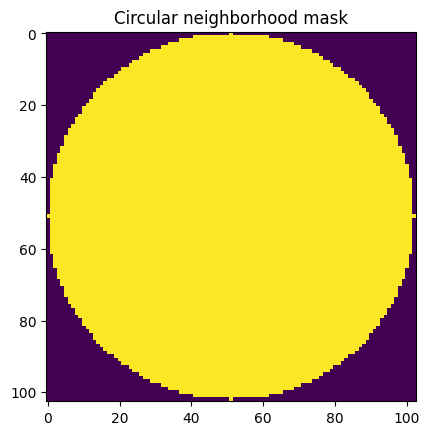

In [43]:
def circular_neighborhood_mask(r):
    A = jnp.arange(-r,r+1)**2
    dists = jnp.sqrt(A[:,None] + A)
    return (jnp.abs(dists)<=r).astype(int)

plt.imshow(circular_neighborhood_mask(51))
plt.title("Circular neighborhood mask")
plt.show()

[]

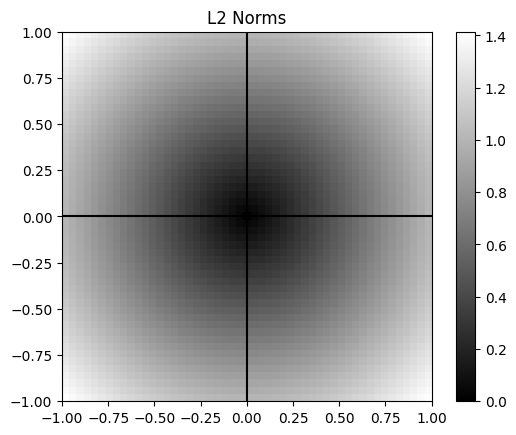

In [44]:
x = jnp.linspace(-1, 1, 51)
y = jnp.linspace(-1, 1, 51)
l2_norms = jnp.sqrt(x[:,None]**2 + y**2)

plt.imshow(l2_norms, origin='lower', cmap='gray', extent=(-1,1,-1,1))
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.colorbar()
plt.title('L2 Norms')
plt.plot()

In [45]:
def exp_kernel_core(alpha, r):
    r = jnp.where(r==1, 0, r)  # Handle division by zero
    return jnp.exp(alpha - alpha / (4*r*(1-r)))

def poly_kernel_core(alpha, r):
    
    r = jnp.where(r==1, 0, r)   # Handle division by zero
    return (4*r*(1 - r))**alpha




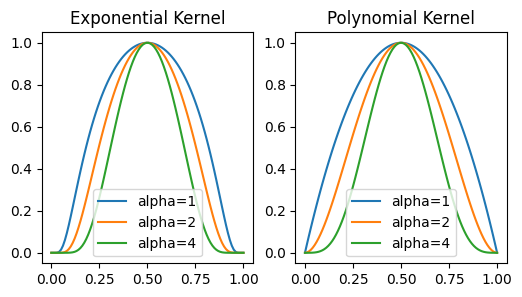

In [46]:
#plotting the kernels
r = jnp.linspace(0, 1, 100)
#2 plots
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
#plotting the exponential kernel
axs[0].plot(r, exp_kernel_core(1, r), label='alpha=1')
axs[0].plot(r, exp_kernel_core(2, r), label='alpha=2')
axs[0].plot(r, exp_kernel_core(4, r), label='alpha=4')
axs[0].set_title('Exponential Kernel')
axs[0].legend()
#plotting the polynomial kernel
axs[1].plot(r, poly_kernel_core(1, r), label='alpha=1')
axs[1].plot(r, poly_kernel_core(2, r), label='alpha=2')
axs[1].plot(r, poly_kernel_core(4, r), label='alpha=4')
axs[1].set_title('Polynomial Kernel')
axs[1].legend()
plt.show()


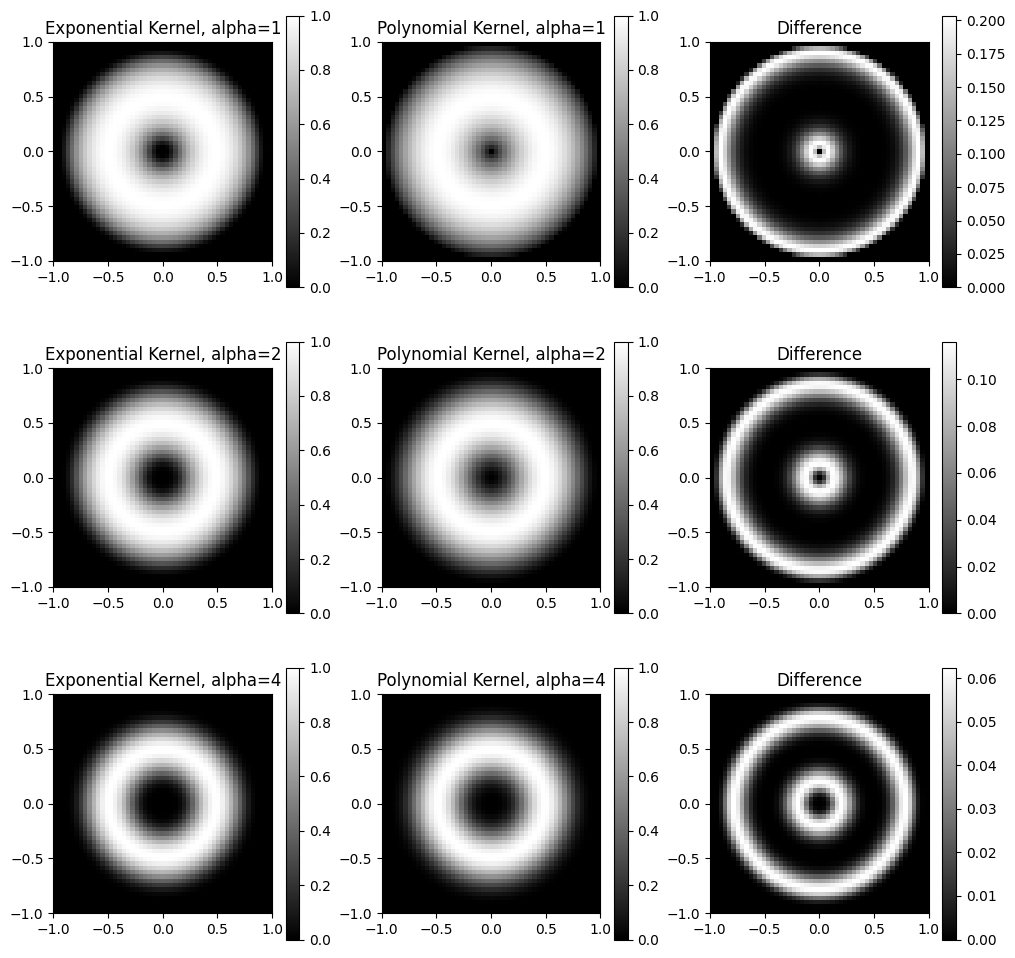

In [47]:
#plot kernel in 2D space with l2 norms K(x,y) = exp(-alpha*||x-y||^2)

x = jnp.linspace(-1, 1, 51)
y = jnp.linspace(-1, 1, 51)
l2_norms = jnp.sqrt(x[:,None]**2 + y**2)

fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for i, alpha in enumerate([1, 2, 4]):

    exp_kernel = exp_kernel_core(alpha, l2_norms)
    exp_kernel = jnp.where(l2_norms>1, 0, exp_kernel)

    poly_kernel = poly_kernel_core(alpha, l2_norms)
    poly_kernel = jnp.where(l2_norms>1, 0, poly_kernel)

    difference = jnp.abs(exp_kernel - poly_kernel)

    im = axs[i, 0].imshow(exp_kernel, origin='lower', cmap='grey', extent=(-1,1,-1,1), vmin=0, vmax=1)
    axs[i, 0].set_title(f'Exponential Kernel, alpha={alpha}')
    fig.colorbar(im, ax=axs[i, 0])
    im = axs[i, 1].imshow(poly_kernel, origin='lower', cmap='grey', extent=(-1,1,-1,1), vmin=0, vmax=1)
    axs[i, 1].set_title(f'Polynomial Kernel, alpha={alpha}')
    fig.colorbar(im, ax=axs[i, 1])
    im = axs[i, 2].imshow(difference, origin='lower', cmap='grey', extent=(-1,1,-1,1), vmin=0)
    axs[i, 2].set_title('Difference')
    fig.colorbar(im, ax=axs[i, 2])

plt.show()


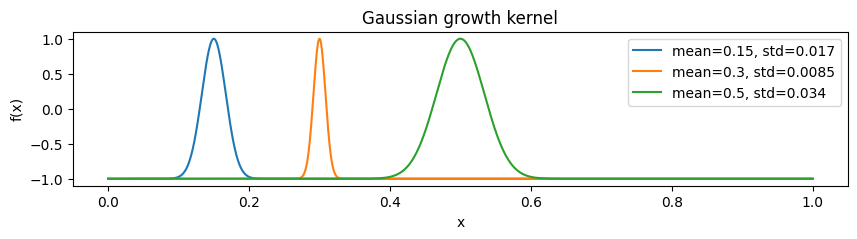

In [48]:
def gaussian_growth_kernel(x, mean, std):
    return 2*jnp.exp((-jnp.abs((x-mean))**2) / (2*(std**2)))-1

def poly_growth_kernel(x, mean, std, alpha):
    # TODO: Implement the polynomial growth kernel
    pass

x = jnp.linspace(0, 1, 1000)
y_1 = gaussian_growth_kernel(x, 0.15, 0.017)
y_2 = gaussian_growth_kernel(x, 0.3, 0.0085)
y_3 = gaussian_growth_kernel(x, 0.5, 0.034)
plt.figure(figsize=(10,2))
plt.title("Gaussian growth kernel")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y_1, label='mean=0.15, std=0.017')
plt.plot(x, y_2, label='mean=0.3, std=0.0085')
plt.plot(x, y_3, label='mean=0.5, std=0.034')
plt.legend()
plt.show()



In [49]:
@jax.jit
def update_state(state: jnp.ndarray, kernel: jnp.ndarray, mean: float = 0.15, 
                 std: float = 0.017, dt: float = 1):
    #pad state with 
    padded_state = jnp.pad(state, kernel.shape[0]//2, mode='wrap')
    delta_state = jax.scipy.signal.convolve2d(padded_state, kernel, mode='valid')/jnp.sum(kernel)
    delta_state = gaussian_growth_kernel(delta_state, mean, std)
    new_state = state + dt * delta_state
    new_state = jnp.clip(new_state, 0, 1)
    return new_state


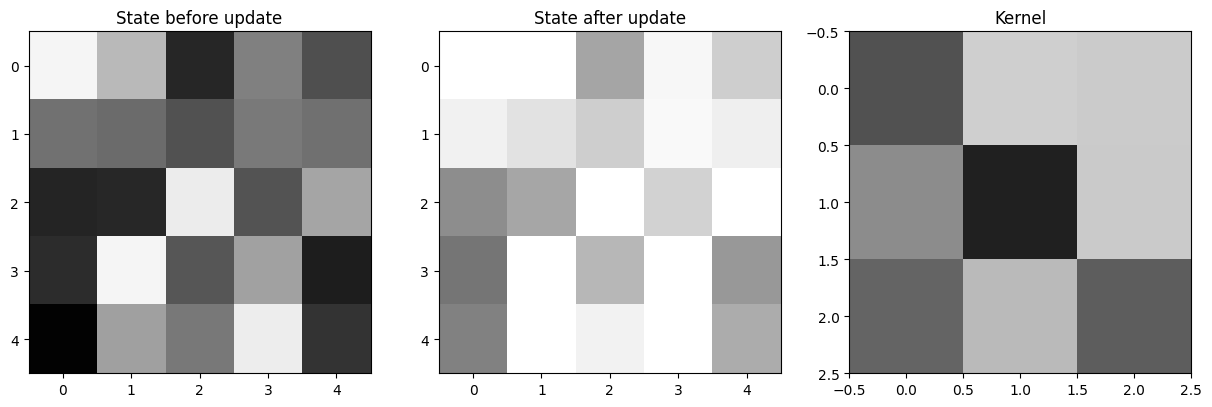

In [50]:
"""
Update example
"""

dummy_state = np.random.rand(5, 5)
dummy_kernel = np.random.rand(3, 3)
mean = 0.5
std = 0.3
dt = 0.5
updated_state = update_state(dummy_state, dummy_kernel, mean=mean, std=std, dt=dt)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(dummy_state, cmap="gray", vmin=0, vmax=1)
ax[0].set_title("State before update")
ax[1].imshow(updated_state, cmap="gray", vmin=0, vmax=1)
ax[1].set_title("State after update")
ax[2].imshow(dummy_kernel, cmap="gray", vmin=0, vmax=1)
ax[2].set_title("Kernel")
plt.show()

In [51]:
%matplotlib notebook

state = np.random.rand(20, 20)
kernel = np.random.rand(5, 5)
mean = 0.5
std = 0.3
dt = 0.01

num_steps = 300
states = [state]
for i in range(num_steps):
    state = update_state(state, kernel, mean=mean, std=std, dt=dt)
    states.append(state)


states = np.array(states)
fig = plt.figure()

im = plt.imshow(states[0,:,:], cmap='viridis', vmin=0, vmax=1)
#dont plot im
def init():
    im.set_data(states[0,:,:])
    return (im,)

# animation function. This is called sequentially
def animate(i):
    data_slice = states[i,:,:]
    im.set_data(data_slice)
    return (im,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=num_steps, interval=20, blit=True)

HTML(anim.to_html5_video())



<IPython.core.display.Javascript object>

(42, 40)


Text(0.5, 1.0, 'Orbium')

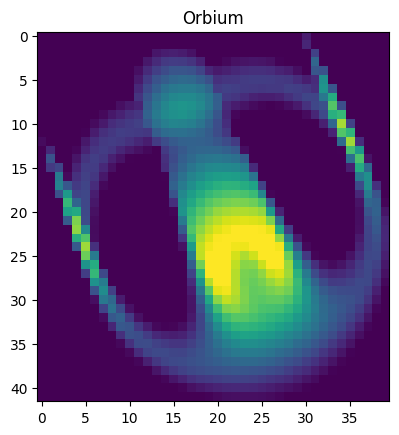

In [52]:
%matplotlib inline
#plot orbium
img_array = np.loadtxt("./orbium.txt")
print(img_array.shape)
#Plot
plt.imshow(img_array)
plt.title("Orbium")

In [54]:
%matplotlib notebook

img_array = np.loadtxt("./orbium.txt")

pad_horizontal = (100 - img_array.shape[0]) // 2
pad_vertical = (100 - img_array.shape[1]) // 2

img_array = np.pad(img_array, ((pad_horizontal, pad_horizontal), (pad_vertical, pad_vertical)), mode='constant', constant_values=0)


kernel_radius = 26
x = np.linspace(-1, 1, kernel_radius*2+1)
y = np.linspace(-1, 1, kernel_radius*2+1)
l2_norms = np.sqrt(x[:,None]**2 + y**2)

kernel = exp_kernel_core(4, l2_norms)
kernel = np.where(l2_norms>1, 0, kernel)

mean = 0.15
std = 0.017
dt = 0.1

states = [img_array]
num_steps = 300
for i in range(num_steps):
     img_array = update_state(img_array, kernel, mean=mean, std=std, dt=dt)
     states.append(img_array)
states = np.array(states)


fig = plt.figure()
im = plt.imshow(states[0,:,:])
#title
plt.title("Orbium")

def init():
    im.set_data(states[0,:,:])
    return (im,)

# animation function. This is called sequentially
def animate(i):
    data_slice = states[i,:,:]
    im.set_data(data_slice)
    return (im,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=num_steps, interval=20, blit=True)

HTML(anim.to_html5_video())

<IPython.core.display.Javascript object>

In [65]:
%matplotlib notebook

img_array = np.random.rand(100, 100)

kernel_radius = 13
x = np.linspace(-1, 1, kernel_radius*2+1)
y = np.linspace(-1, 1, kernel_radius*2+1)
l2_norms = np.sqrt(x[:,None]**2 + y**2)

kernel = exp_kernel_core(1, l2_norms)
kernel = np.where(l2_norms>1, 0, kernel)

mean = 0.16
std = 0.025
dt = 0.1

states = [img_array]
num_steps = 300
for i in range(num_steps):
     img_array = update_state(img_array, kernel, mean=mean, std=std, dt=dt)
     states.append(img_array)
states = np.array(states)


fig = plt.figure()
im = plt.imshow(states[0,:,:])
#title
plt.title("Gaussian noise")

def init():
    im.set_data(states[0,:,:])
    return (im,)

# animation function. This is called sequentially
def animate(i):
    data_slice = states[i,:,:]
    im.set_data(data_slice)
    return (im,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=num_steps, interval=20, blit=True)

HTML(anim.to_html5_video())

<IPython.core.display.Javascript object>